In [ ]:
import os
from PIL import Image
import cv2
import torch.utils.data as torch_data
import torchvision
import torch
import time
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

In [ ]:
save_path = '../15d_vae/{}'
code_size = 15

train = 1
beta = 1
early_stopping = 1
if early_stopping:
    epochs = 100 #for early stopping only 

In [ ]:
torch.manual_seed(42)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f'Selected device: {device}')
print(torch.version.cuda)

Selected device: cuda:0
11.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab_Notebooks/padded_300/hydra_images/hydra_processed'
os.chdir(path)
print(os.getcwd())
print(len(os.listdir()))
#os.listdir(path)
image_folder = path

/content/drive/MyDrive/Colab_Notebooks/padded_300/hydra_images/hydra_processed
10040


In [ ]:
class Dataset(torch_data.Dataset):
    """
    A class for feeding image data into the autoencoder
    
    Note RGB removed
    Ignore all functions that set labels
    __getitem__ modified to only give image (called batch when used by train_one_epoch())
    added min-max scaling to convert values to 1 and 0 to use binary cross entropy
    by using cv2.imread(path, 0) converts to greyscale putting into dimensions [1, 300, 300]
    added a property called orig_max - to later reverse min-max scaling
    paths in __init__ is modified to work in same notebook as execution - 
    so included the attribute image_folder
    
    
    """


    def __init__(self, img_transforms, image_folder):
        """
        - transforms: transforms to apply to the images
        - RGB: whether to process in color
        - image_folder: data directory

        """
        self.img_transforms = img_transforms
        self.image_folder = image_folder
        
        #append all filenames 
        self.paths = [file for file in os.listdir(self.image_folder) if file.endswith('.png')]    

        self.labels = [0 for path in self.paths]


    def __getitem__(self, index):

        path = self.paths[index]
        label = self.labels[index]

        image = cv2.imread(path, 0)#grey scale 3->1

        image = Image.fromarray(image)
        

        image = self.img_transforms(image)
        
        #min-max scaling so values take 1 or 0
        image = torch.div(image, torch.max(image))

        return (path, image, label)


    def __len__(self):
        return len(self.labels)

In [ ]:
#functions from utils

def get_lims_from_points(points):
    xs, ys = [], []
    for item in points:
        xs.append(item[0][0])
        ys.append(item[0][1])
    min_x, max_x, min_y, max_y = min(xs), max(xs), min(ys), max(ys)
    return min_x, max_x, min_y, max_y

def _standardize_coords(coords, orig_lims):
    [xmin, xmax, ymin, ymax] = orig_lims
    x_new = -10 + 20*(coords[0]-xmin)/(xmax-xmin)
    y_new = -10 + 20*(coords[1]-ymin)/(ymax-ymin)
    return [x_new, y_new]


class Flatten(torch.nn.Module):
    def forward(self, batch):
        return batch.view(batch.shape[0], -1)

class UnFlatten(torch.nn.Module):
    def __init__(self, num_reps, height, width):
        super(UnFlatten, self).__init__()
        self.num_reps = num_reps
        self.height = height
        self.width = width
    def forward(self, batch):
        return batch.view(batch.shape[0], self.num_reps, self.height, self.width)

#
flatten = Flatten()


In [ ]:

#visualization class
#Here we only use code_projections_2D


class Visualizations_Mixin:

    def code_projections_2D(self, im_size, save_path, proj_sampling_rate):
        """
        inherit this function using VAE - so can run VAE.code_projections_2D()
        likewise implement_autoencoder inherits so:
        implement_autoencoder.VAE.code_projections_2D((200, 200)
         save_path = implement_autoencoder.save_path, proj_sampling_rate = 15)

        Sample code space on grid and visualize the features the network
        is capturing.
        Args:
        - im_size: tuple of dimensions of each image on the grid.
        - save_as: filename to save image as.
        - proj_sampling_rate: number of samples along each axis.
        """

        self.eval()

        # set the limits of the grid to project from to be either data_lims (set by running the function that
        # finds the min & max of data embeddings), or lims_list which is specified when initializing the VAE class
        if self.data_limits is None:
            min_x, max_x = self.lims_list[0], self.lims_list[1]
            min_y, max_y = self.lims_list[2], self.lims_list[3]
        else:
            min_x, max_x = self.data_limits[0], self.data_limits[1]
            min_y, max_y = self.data_limits[2], self.data_limits[3]

        im_array = np.zeros((int(max_y) - int(min_y), int(max_x) - int(min_x)))

        # split the code space into grid
        grid_xs = np.linspace(min_x, max_x, proj_sampling_rate)
        grid_ys = np.linspace(min_y, max_y, proj_sampling_rate)
        x_im_width = grid_xs[1]-grid_xs[0]
        y_im_width = grid_ys[1]-grid_ys[0]

        # dimension of each image to be plottted
        im_dimension = 200

        # empty array to fill with the images
        array = np.zeros( ( im_dimension * len(grid_ys), im_dimension * len(grid_xs) ) )

        fig = plt.figure(figsize = (50, 50))
        # i, j for placement in empty array; x, y initial codes
        for i, x in enumerate(grid_xs):
            x += (x_im_width/5) # so spore is at code point
            for j, y in enumerate(grid_ys):
                y += y_im_width/2
                code = torch.tensor([x, y], dtype = torch.float32)
                code = torch.unsqueeze(code, 0)
                code = code.to(device)
                #batch = F.relu(batch)
                code = self.fc2(code)
                batch = self.decoder(code)

                batch = batch.view(*im_size)
                im = batch.detach().cpu().numpy() # need to detach from graph before it can be turned into array

                im = cv2.resize(im, (im_dimension, im_dimension))

                row1 = im_dimension * j
                row2 =  im_dimension * j + im_dimension
                col1 = im_dimension * i
                col2 = im_dimension * i + im_dimension
                array[row1:row2, col1:col2] = im[::-1, :] # filling the empty array with the images

        array = array[::-1, :]*255

        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False)
        plt.imshow(array, cmap='gray')
        plt.savefig(save_path.format('code_projections'))
        plt.close()

        self.proj_array = array
        self.proj_array_im_dim = im_dimension
        self.proj_sampling_rate = proj_sampling_rate




    def scatter_1drug_allSnaps(self, drug, idx_drug, save_path):
        """
        ( After dataset.keep_one_drug_timeLabelled() )
        Scatter for each temporal snapshot, for a single drug.
        Args
        - save_as: save path
        """

        # set the limits of the grid to project from to be either data_lims (set by running the function that
        # finds the min & max of data embeddings), or lims_list which is specified when initializing the VAE class
        if self.data_limits is None:
            xmin, xmax = self.lims_list[0], self.lims_list[1]
            ymin, ymax = self.lims_list[2], self.lims_list[3]
        else:
            xmin, xmax = self.data_limits[0], self.data_limits[1]
            ymin, ymax = self.data_limits[2], self.data_limits[3]

        xs, ys, labels = [], [], []
        for item in self.points:
            xs.append(item[0][0])
            ys.append(item[0][1])
            labels.append(item[1])


        data_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[]}

        for i in range(len(xs)):
            data_dict[labels[i]].append((xs[i], ys[i]))

        labels_to_colours = {0 :colors.to_rgba('lightgrey'), 1 : colors.to_rgba('magenta'), 2: colors.to_rgba('deepskyblue'), 3:colors.to_rgba('orangered') , 4:colors.to_rgba('springgreen') , 5: colors.to_rgba('darkgreen')}

        fig = plt.figure(figsize = (70, 40))
        for idx_time, coords in data_dict.items():
            ax = fig.add_subplot(1, 9, idx_time+1)
            coords = [_standardize_coords(c, orig_lims = [xmin, xmax, ymin, ymax]) for c in coords]
            ax.scatter([c[0] for c in coords], [c[1] for c in coords], s = 5, c = labels_to_colours[idx_drug])
            ax.set_xlim([-10, 10])
            ax.set_ylim([-10, 10])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
        plt.savefig(save_path.format(drug))
        plt.close()



    def graphic_drugOrtime_1snap(self, which_colors, save_path):
        """
        Plots a single 2D graphic, either
        a) Snapshot of all drugs at a specific time point.
        b) Single drug with different time snaps.
        Args
        - save_as
        - which_colors: colors depending if executing (a) or (b)
        """

        if which_colors == 'drug_colors':
            labels_to_colours = {0 :colors.to_rgba('lightgrey'), 1 : colors.to_rgba('magenta'), 2: colors.to_rgba('deepskyblue'), 3:colors.to_rgba('orangered') , 4:colors.to_rgba('springgreen') , 5: colors.to_rgba('darkgreen')}
        elif which_colors == 'time_colors':
            labels_to_colours = {0 : (1, 0.9, 0.9), 1 : (1, 0.8, 0.8), 2 : (1, 0.7, 0.7), 3 : (1, 0.6, 0.6), 4: (1, 0.5, 0.5), 5: (1, 0.4, 0.4), 6: (1, 0.3, 0.3), 7: (1, 0.2, 0.2), 8: (1, 0.1, 0.1)}


        xs, ys, colours = [], [], []

        for item in self.points:
            xs.append(item[0][0])
            ys.append(item[0][1])
            colours.append(labels_to_colours[item[1]])

        fig = plt.figure(figsize = (20, 20))
        ax = fig.add_subplot(111)
        ax.scatter(xs, ys, c = colours)
        ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))

        plt.savefig(save_path.format('dots'))
        plt.close()


        # set the limits of the grid to project from to be either data_lims (set by running the function that
        # finds the min & max of data embeddings), or lims_list which is specified when initializing the VAE class
        if self.data_limits is None:
            min_x, max_x = self.lims_list[0], self.lims_list[1]
            min_y, max_y = self.lims_list[2], self.lims_list[3]
        else:
            min_x, max_x = self.data_limits[0], self.data_limits[1]
            min_y, max_y = self.data_limits[2], self.data_limits[3]


        x_range = max_x - min_x
        y_range = max_y - min_y

        array_dim = 2200
        ims_array = np.zeros((array_dim, array_dim, 3), dtype = np.uint8)
        ims_array+=255
        random.shuffle(self.points)

        for item in self.points:
            label = item[1]

            path = item[2]
            im = cv2.imread(path, 0)

            _, thresh = cv2.threshold(im, 30, 255, cv2.THRESH_BINARY)

            cv2.circle(thresh, (int(thresh.shape[1]/5)-5, int(thresh.shape[0]/2)), 8, 255, -1)

            contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            if len(contours) > 0:
                for contour in contours:
                    x_start = int(((array_dim-200)/x_range)*(item[0][0] + abs(min_x)))
                    y_start = int(((array_dim-200)/y_range)*(item[0][1] + abs(min_y)))

                    # so the spore is at the code point
                    contour[:, :, 0] -= int(thresh.shape[1]/5)-5
                    contour[:, :, 1] -= int(thresh.shape[0]/2)

                    contour[:, :, 0] += x_start
                    contour[:, :, 1] += array_dim - y_start

                    colour_increased = np.array(labels_to_colours[label])*255
                    cv2.drawContours(ims_array, [contour], -1, colour_increased, -1)

        fig, ax = plt.subplots(1, figsize=(100, 100))
        ax.imshow(ims_array[200:, :-200])
        plt.savefig(save_path.format('morphologies'))
        plt.close()

        return ims_array


In [ ]:

class VAE(torch.nn.Module, Visualizations_Mixin):
    """
    Variational Autoencoder (with beta = 0 this becomes a regular autoencoder, as used in the paper)
    """

    def __init__(self, code_size, beta, learning_rate, batch_size, lims_list):
        """
        - code_size
        - beta: KLD weighting in loss
        - learning_rate
        - batch_size
        - lims_list: minimum and maximum along each morphospace dimension for visualizations; [xmin, xmax, ymin, ymax]
        """
        super(VAE, self).__init__()

        self.learning_rate = learning_rate
        self.code_size = code_size
        self.batch_size = batch_size
        self.beta = beta

        self.lims_list = lims_list #declared in run_morphospace.py, change later to worm specif values
        self.data_limits = None # a switch for visualization, for axis limits
        self.points = None #by calling fx turns into a list of embeddings

        self.num_epochs_trained = 0
        self.BCE = []
        self.BCE_plot = []


        self.input_dims = [300, 300] #change for image height/width
        ########################################################################
        act_func = torch.nn.ReLU()
        final_act = torch.nn.Sigmoid()
        ##############################

        conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        bn1 = torch.nn.BatchNorm2d(16)
        
        conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        bn2 = torch.nn.BatchNorm2d(32)
        
        conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        bn3 = torch.nn.BatchNorm2d(64)
        
        conv4 = torch.nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1)
        bn4 = torch.nn.BatchNorm2d(16)


        self.encoder = torch.nn.Sequential(conv1, bn1, act_func,
                                         conv2, bn2, act_func,
                                         conv3, bn3, act_func,
                                         conv4, bn4, act_func,
                                         Flatten())
        self.encoder.apply(self.init_weights)
        ########################################################################
        #make sure linear layer is 300*300 neurons
        self.fc11 = torch.nn.Linear(90000, self.code_size)
        self.fc12 = torch.nn.Linear(90000, self.code_size) #for VAE reparamertiztion 
        self.fc2 = torch.nn.Linear(self.code_size, 90000)
        
        for i in [self.fc11, self.fc12, self.fc2]:
            i.apply(self.init_weights)
        ########################################################################

        conv5 = torch.nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        bn5 = torch.nn.BatchNorm2d(64)
        
        conv6 = torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
        bn6 = torch.nn.BatchNorm2d(32)
        
        conv7 = torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        bn7 = torch.nn.BatchNorm2d(16)
        
        conv8 = torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1)

        self.decoder = torch.nn.Sequential(UnFlatten(16, 75, 75), #change to 75 for worm image dimensions
                                            conv5, bn5, act_func, 
                                            conv6, bn6, act_func, 
                                            conv7, bn7, act_func,
                                             conv8, final_act)
        self.decoder.apply(self.init_weights)
        ########################################################################

    def init_weights(self, m):
        """
        Xavier initialization
        """
        if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

    def set_data_limits(self, dataloader):
        """
        Find and set as attribute the morphospace limits, for visualizations

        as an alternative to self.lims_list, this fx looks at the embeddings to
        get the min and max for the set of embeddings 
        which is used in the visualization script to set the axis limits 
        """

        self.eval()#dont calaculate gradients

        xs, ys = [], []
        for i, tup in enumerate(dataloader):
            if i % 100 == 0:
                print('batch {}'.format(i))
                sys.stdout.flush()
            paths, batch, labels = tup[0], tup[1], tup[2]
            batch = batch.type('torch.FloatTensor').to(device)
            labels = labels.to(device)

            intermediate = batch

            intermediate = self.encoder(intermediate)
            mu_ = self.fc11(intermediate) #code space
            mu_ = mu_.data.cpu().numpy() #take out of cuda and handle with numpy

            labels_ = labels.data.cpu().numpy()
            for idx in range(mu_.shape[0]): #get each image in batch
                xs.append(mu_[idx, :][0]) #embedding 1
                ys.append(mu_[idx, :][1]) #embedding 2

        self.data_limits = (min(xs), max(xs), min(ys), max(ys)) #axis limits for visualisation 

    def _reparametrize(self, mu, logvar):
        """
        Central reparametrization
        Args:
        - mu: mean of stochastic embedding.
        - logvar: logarithm variable.

        batch normalization for the code spcae
        """

        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(device) # default mean 0, std 1
        return eps.mul(std).add_(mu)


    def forward(self, x):
        """
        Propagate batch
        Args:
        - x: batch to flow through.
        """
        x = self.encoder(x)

        mu = self.fc11(x)
        logvar = self.fc12(x)
        x = self._reparametrize(mu, logvar)

        x = self.fc2(x)

        recon_x = self.decoder(x)

        return mu, logvar, recon_x

    def _custom_loss(self, recon_x, x, mu, logvar):
        """
        Loss is reconstruction and weighted KLD. The latter is difference between unit Gaussian
        and each point's stochastic (and also Gaussian) embedding.
        Args:
        - recon_x: reconstuction
        - x: input data
        - mu: mean of stochastic embedding.
        - logvar: log variable of stochastic embedding.
        """

        #bce = F.binary_cross_entropy(torch.add(recon_x, 1e-10), x, size_average=False)
        bce = F.binary_cross_entropy(recon_x, x, size_average=False)
        kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        loss = bce + self.beta*kld.sum()

        bce /= x.shape[0]
        kld_loss = self.beta*kld.sum()/x.shape[0]
        loss /= x.shape[0]

        return bce, kld_loss, loss


    def train_oneEpoch(self, dataloader, save_recons_path = save_path):
        """
        Train the model for one epoch.
        Args
        - dataloader: PyTorch dataloader object
        - save_recons_path: where to save reconstructions each epoch
        """

        self.train()

        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)


        MSE_losses = []
        KLD_losses = []

        for i, tup in enumerate(dataloader):
            start_time = time.time()

            if i % 50 == 0:
                print('batch {}'.format(i))
                sys.stdout.flush()

            _, batch, _ = tup[0], tup[1], tup[2]


            batch = batch.type('torch.FloatTensor').to(device)

            # forward
            mu, logvar, x = self.forward(batch) #code error, put forward
            #print(torch.unique(x))
            #sys.stdout.flush()

            if save_recons_path is not None:
                # visualise some reconstructions
                if i == 10:

                    fig, axarr = plt.subplots(6, 6, figsize=(70, 40))
                    count = 0
                    for row_start in [0, 2, 4]:
                        for col in range(6):
                            axarr[row_start, col].imshow(batch.detach().cpu().view(batch.size(0), self.input_dims[0], self.input_dims[1])[count + col, :], cmap = 'gray')
                            axarr[row_start, col].set_title('{}_{}'.format(torch.min(batch).item(), torch.max(batch).item()))
                            axarr[row_start + 1, col].imshow(x.detach().cpu().view(x.size(0), self.input_dims[0], self.input_dims[1])[count + col, :], cmap='gray') # detach as can't call numpy() on requires_grad var
                            axarr[row_start + 1, col].set_title('{}_{}'.format(torch.min(x).item(), torch.max(x).item()))
                        count += 6
                    plt.axis('off')
                    plt.savefig(save_recons_path.format(self.num_epochs_trained))
                    plt.close(fig)


            MSE, beta_KLD, loss = self._custom_loss(x, batch, mu, logvar)
            #print(MSE.item())
            #sys.stdout.flush()

            MSE_losses.append(MSE.item())
            KLD_losses.append(beta_KLD.item())
            self.BCE.append(MSE.item())

            # backward pass
            optimizer.zero_grad() #clear gradients for iteration
            loss.backward() #backpropogation 
            optimizer.step() #update gradients

        print('Epoch {}, MSE_loss: {}, KLD_loss: {}, Loss: {}'.format(self.num_epochs_trained, MSE, beta_KLD, loss.item()))
        self.num_epochs_trained += 1
        self.BCE_plot.append(loss.item())
        


    def harvest_points(self, dataloader):
        """
        Save embeddings as a class attribute (self.points).
        Args
        - dataloader: PyTorch dataloader object to be modelled.

        for each make a list of embeddings to be used in the visualization script
        """

        self.eval() #dont update gradients 

        points = []
        for i, tup in enumerate(dataloader):
            if i % 100 == 0:
                print('batch {}'.format(i))
                sys.stdout.flush()

            paths, batch, labels = tup[0], tup[1], tup[2]
            batch = batch.type('torch.FloatTensor').to(device)
            labels = labels.to(device)

            batch = self.encoder(batch)
            mu_ = self.fc11(batch)
            mu_ = mu_.data.cpu().numpy()

            labels_ = labels.data.cpu().numpy()
            for idx in range(mu_.shape[0]):
                points.append([mu_[idx, :], labels_[idx], paths[idx]]) #list of code space

        self.points = points




    def save(self):
        """
        Save the model's state_dict under arg: save_path.
        """
        torch.save(self.state_dict(), save_path.format('model_parameters.pth.tar'))


    def load(self):
        """
        Load the model's state_dict from arg: path.
        """
        self.load_state_dict(torch.load(save_path.format('model_parameters.tar') , map_location=torch.device(device)))




In [ ]:
class Implement_Autoencoder():
    """
    Class for operations using the VAE class.
    """


    def __init__(self, code_size, beta, lr, batch_size, lims_list, save_path):
        """
        Args
        - code_size: dimensionality of the morphospace
        - beta: weighting of the Kullback-Leibler divergence in the VAE loss (this is zero for a plain autoencoder)
        - lr: learning rate
        - batch_size
        - save_path: path to save visualizations to. Must include '{}' to be formatted with visualization-specific string
        """

        self.code_size = code_size
        self.beta = beta
        self.lr = lr
        self.batch_size = batch_size
        self.save_path = save_path

        self.VAE = None
        
        # for dataloader
        self.img_transforms = torchvision.transforms.Compose(  [torchvision.transforms.ToTensor()] ) # convert images to PyTorch tensor objects
        self.image_folder = image_folder
        
        self.lims_list = lims_list


    def load_model(self):
        """
        Load the neural network state_dict from disk.
        """

        self.VAE = VAE(self.code_size, self.beta, self.lr, self.batch_size, self.lims_list).to(device)
        self.VAE.load()


    def train_and_save_model(self, num_epochs_train):
        """
        Train and save state_dict.
        """
        self.VAE = VAE(self.code_size, self.beta, self.lr, self.batch_size, self.lims_list).cuda()
        dataset = Dataset(self.img_transforms, self.image_folder) #, RGB = False) modify dataset to get this 
        #dataset.drug_labelled() #modify dataset to get this

        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = self.batch_size, shuffle = True)

        
        for epoch in range(num_epochs_train):
            self.VAE.train_oneEpoch(train_dataloader)
            #path_to_here = os.path.dirname(os.path.realpath(__file__))
            #self.VAE.save(path_to_here+'/../outputs/autoencoder_{}.pth.tar'.format(self.VAE.num_epochs_trained))

            #lots of visualization stuff to add in later


    def set_data_limits_all(self):
        """
        Find the minimum and maximum along each morphospace dimension (for plotting visualizations)
        """
        dataset = Dataset(self.img_transforms, self.image_folder) #, RGB = False)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size = self.batch_size, shuffle = True)
        self.VAE.set_data_limits(dataloader)


In [ ]:

class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

        self.img_transforms =  torchvision.transforms.Compose(  [torchvision.transforms.ToTensor()] ) # convert images to PyTorch tensor objects
        self.image_folder = image_folder
        self.batch_size = 50

        self.val_loss = []


    def __call__(self, val_loss, model):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
        if self.counter == 1:
            model.save()
            

    #run validation


    def validate_oneEpoch(self, model, dataloader):
        model.eval()
        loss_total = 0 

        with torch.no_grad():
            for i, tup in enumerate(dataloader):
                _, batch, _ = tup[0], tup[1], tup[2]
                batch = batch.type('torch.FloatTensor').to(device)
                mu, logvar, x = model.forward(batch)
                _, _, loss = model._custom_loss(x, batch, mu, logvar)
                loss_total += loss.item()  #sum loss scores

        self.val_loss.append(loss_total/len(valid_loader)) #average loss across batch
        print('Epoch {}, loss: {}'.format(epoch, self.val_loss[-1]))
            

    
          




10040 8534 1506 10040
torch.Size([1, 300, 300])
Epoch 1 of 100
batch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


batch 50
batch 100
batch 150
Epoch 0, MSE_loss: 20351.57421875, KLD_loss: 64.50776672363281, Loss: 20416.080078125
Epoch 0, loss: 21759.831968245966
20416.080078125 21759.831968245966
Epoch 2 of 100
batch 0
batch 50
batch 100
batch 150
Epoch 1, MSE_loss: 8371.7412109375, KLD_loss: 51.07362365722656, Loss: 8422.814453125
Epoch 1, loss: 7991.891948084677
8422.814453125 7991.891948084677
Epoch 3 of 100
batch 0
batch 50
batch 100
batch 150
Epoch 2, MSE_loss: 3754.32275390625, KLD_loss: 50.87753677368164, Loss: 3805.200439453125
Epoch 2, loss: 3760.3500189012098
3805.200439453125 3760.3500189012098
Epoch 4 of 100
batch 0
batch 50
batch 100
batch 150
Epoch 3, MSE_loss: 2666.98291015625, KLD_loss: 66.6019287109375, Loss: 2733.5849609375
Epoch 3, loss: 2312.918031754032
2733.5849609375 2312.918031754032
Epoch 5 of 100
batch 0
batch 50
batch 100
batch 150
Epoch 4, MSE_loss: 1573.7696533203125, KLD_loss: 65.49249267578125, Loss: 1639.26220703125
Epoch 4, loss: 1685.2350641066027
1639.26220703125

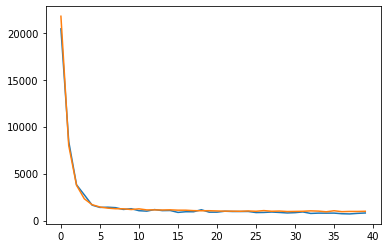

[75438.0859375, 74376.7421875, 72856.2734375, 71011.5390625, 68695.3359375, 66364.515625, 64178.16015625, 62041.27734375, 60222.37890625, 58759.1171875, 57529.40234375, 56332.1171875, 55362.71484375, 54532.0078125, 53834.91796875, 52962.23828125, 52204.9296875, 51657.66796875, 51017.67578125, 50442.078125, 49726.44921875, 49345.46875, 48842.984375, 48296.3984375, 47816.26953125, 47354.41015625, 47027.19921875, 46732.48046875, 46068.3125, 45863.1328125, 45322.42578125, 44786.203125, 44307.125, 44214.1796875, 43859.953125, 43551.828125, 42965.87890625, 42613.25, 42190.6953125, 41865.36328125, 41584.9375, 41316.22265625, 41316.44140625, 40686.328125, 40410.890625, 40054.328125, 40058.71875, 39613.95703125, 39300.8203125, 39294.4140625, 39103.03515625, 38463.90234375, 38352.0078125, 38053.734375, 37749.11328125, 37569.2109375, 37433.8203125, 37114.8359375, 36858.4921875, 36632.91015625, 36502.89453125, 36482.47265625, 36143.80078125, 35534.16015625, 35440.7890625, 35375.18359375, 35307.425

<Figure size 432x288 with 0 Axes>

In [ ]:

if early_stopping == 1 and train == 1:
    # instantiate early stopping 
    es = EarlyStopping()

    #load dataset
    data = Dataset(es.img_transforms, es.image_folder)

    #number of images in each set (80/20 split)
    train_size = int(len(data) * 0.85)
    valid_size = len(data) - train_size

    #random split
    train_set, valid_set = torch_data.random_split(data, [train_size, valid_size])

    #load data batch
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = es.batch_size, shuffle = True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = es.batch_size, shuffle = True)

    #checks 
    print(len(data), len(train_set), len(valid_set), len(train_set)+len(valid_set))
    print(train_set[0][1].shape)

    #training loop with early stopping 
    lims_list = (-10, 70, -50, 55) # limits are normalized for the landscape model so each morphospace axis has limits [-10, 10]
    ae = VAE(code_size = code_size, beta = beta, learning_rate = 1e-4, batch_size = 50, lims_list = lims_list).cuda()

    for epoch in range(epochs):
      if es.early_stop == True:
          break
      else:
          print(f"Epoch {epoch+1} of {epochs}")
          sys.stdout.flush()

          ae.train_oneEpoch(train_loader)
          es.validate_oneEpoch(ae, valid_loader)
          es(es.val_loss[-1], ae)
          print(ae.BCE_plot[-1], es.val_loss[-1])
      if es.counter == 0:
          ae.save()


    #plot early stopping
    plt.figure()
    plt.plot(ae.BCE_plot)
    plt.plot(es.val_loss)
    plt.show()
    plt.savefig(save_path.format('early_stopping'))

    #look at traing, validation loss
    print(ae.BCE,  "\n", es.val_loss)

    #create a txt file with training and validation lossess
    with open(save_path.format('early_stopping.txt'), "w") as out_file:
        out_file.write("training"+"\n"+str(ae.BCE_plot))
        out_file.write("\n"+"validation\n"+str(es.val_loss))


In [ ]:
if early_stopping == 1 and train ==1 and code_size ==2:
    implement_autoencoder = VAE(code_size = code_size, beta = beta, learning_rate = 1e-4, batch_size = 50, lims_list = lims_list).to(device)
    implement_autoencoder.load()
    es = EarlyStopping()

    #get worm embedding specific limits for visualization
    #VAE.data_limits which is initialised to None is switched to limits 

    lims_dataset = Dataset(es.img_transforms, es.image_folder)
    lims_dataloader = torch.utils.data.DataLoader(lims_dataset, batch_size = 32, shuffle = True)
    implement_autoencoder.set_data_limits(lims_dataloader)
    print(implement_autoencoder.data_limits)

    harvest_dataset = Dataset(es.img_transforms, es.image_folder)
    harvest_dataloader = torch.utils.data.DataLoader(harvest_dataset, batch_size = 32, shuffle = True)
    implement_autoencoder.harvest_points(harvest_dataloader)
    print(implement_autoencoder.points[0])
    len(implement_autoencoder.points)

    implement_autoencoder.code_projections_2D((300, 300), save_path = save_path, proj_sampling_rate = 15)


In [ ]:
if early_stopping == 0 and train == 1: 
    #run autoencoder without early stopping 
    lims_list = (-10, 70, -50, 55) # limits are normalized for the landscape model so each morphospace axis has limits [-10, 10]

    implement_autoencoder = Implement_Autoencoder(code_size = code_size, beta = beta, lr = 1e-4, batch_size = 50, lims_list = lims_list, save_path = save_path)
    implement_autoencoder.train_and_save_model(num_epochs_train=15)
    #save final epoch
    implement_autoencoder.VAE.save()
